![Basic network analysis](https://raw.githubusercontent.com/arvest-data-in-context/ml-notebooks/refs/heads/main/docs/images/notebooks/basic-network-analysis.png)

In this notebook, we shall be taking some IIIF Manifests that are stored on [Arvest](https://arvest.app), and using their metadata to create a network visualization of them. The resulting visualization shall be uploaded as an interactive IIIF Manifest to Arvest.

# 0. Setup

Let's begin by installing and importing all of the different components we will need.

In [1]:
print("Installing and importing packages...")

# Uninstall and reinstall packages for a clean environment
!pip uninstall -q -y arvestapi
!pip uninstall -q -y arvesttools
!pip uninstall -q -y jhutils
!pip uninstall -q -y iiif_prezi3
!pip install -q --disable-pip-version-check git+https://github.com/arvest-data-in-context/arvest-api.git
!pip install -q --disable-pip-version-check git+https://github.com/arvest-data-in-context/arvest-api-tools.git
!pip install -q --disable-pip-version-check git+https://github.com/jdchart/jh-py-utils.git
!pip install -q --disable-pip-version-check git+https://github.com/iiif-prezi/iiif-prezi3.git

# Import packages
import arvestapi
import arvesttools.manifest_creation
from jhutils.local_files import read_json, write_json
import jhutils.online_files
import jhutils.images
from jhutils.misc import print_progress_bar, slugify
import os
import iiif_prezi3
import networkx as nx
import uuid
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import copy
import math
import shutil

TEMP_FOLDER = os.path.join(os.getcwd(), "_TEMP")
if os.path.isdir(TEMP_FOLDER) == False:
    os.makedirs(TEMP_FOLDER)

print("👍 Ready!")

Installing and importing packages...
👍 Ready!


# 1. Get Manifests

First, we shall need to find the Manifests which will represent nodes in our network. To do this, we'll connect to Arvest using the [Arvest API](https://github.com/arvest-data-in-context/arvest-api) package.

First, we need to "connect" to Arvest using the Arvest API package. For this, we need our user email and our password which we will give to an instance of the `arvestapi.Arvest()` class. For convenience, we've saved ours in a file which is why we get `LOGIN_DATA` by reading a json file.

In [2]:
# First, let's connect to our Arvest account:
LOGIN_DATA = os.path.join(os.getcwd(), "login_private.json")
credentials = read_json(LOGIN_DATA)

ar = arvestapi.Arvest(credentials["email"], credentials["password"])
print(f"👍 Succesfully connected to Arvest with \"{ar.profile.name}\"")

👍 Succesfully connected to Arvest with "JH"


Next, we'll get all of our Manifests using the `get_manifests()` function, and then find the ones we'll need by filtering them according to some metadata. We have some test content already uploaded to Arvest.

In [3]:
network_content = []

all_manifests = ar.get_manifests()

for i, manifest in enumerate(all_manifests):
    print_progress_bar(i + 1, len(all_manifests), "(searching manifests...)")

    manifest_item_metadata = manifest.get_metadata()
    if manifest_item_metadata["identifier"] == "&&FOLDER-TO-CORPUS":
        network_content.append(manifest)

print(f"🔍 Found {len(network_content)} manifest items!")

|██████████████████████████████████████████████████| 100.0% Complete (searching manifests...)
🔍 Found 18 manifest items!


# 2. Create the network

Now that we have the elements which will be represented by our nodes, we need to create our network from them. To do this, we'll use the [networkx](https://networkx.org/) package. Let's first a network, and add each Manifest to it as a node.

In [4]:
node_dict = {}
network = nx.Graph()

for i, manifest in enumerate(network_content):
    print_progress_bar(i + 1, len(network_content), f"(adding {manifest.title})")

    # Create a unique ID
    node_id = str(uuid.uuid4())

    # Add it to our node dict so we can find it later
    node_dict[node_id] = {"manifest_item" : manifest, "manifest_dict" : manifest.get_content(), "has_manifest" : True}

    # Add the node to the network
    network.add_node(node_id)

print("👍 Finished adding nodes!")

|██████████████████████████████████████████████████| 100.0% Complete (adding _sludge-layer.maxpat))
👍 Finished adding nodes!


In our example, we are creating a network from files that were found in some folders. Let's create a fe more nodes that represent each of the folders.

In [5]:
folder_list = []

def get_metatdata_field(meta, label):
    for item in meta:
        if item["label"]["en"][0] == label:
            return item["value"]["en"][0]

# Get folders: 
for node_id in node_dict:
    node_metadata = node_dict[node_id]["manifest_dict"]["metadata"]
    folder_path = get_metatdata_field(node_metadata, "dir")
    if folder_path not in folder_list:
        folder_list.append(folder_path)

# Add them as nodes:
for item in folder_list:
    node_id = str(uuid.uuid4())
    node_dict[node_id] = {"manifest_item" : None, "manifest_dict" : None, "has_manifest" : False, "folder_label" : item}
    network.add_node(node_id)

print(f"👍 Added {len(folder_list)} folders as nodes.")

👍 Added 3 folders as nodes.


## Display the network
We'll create a small function that allows us to visualize the network in our notebook:

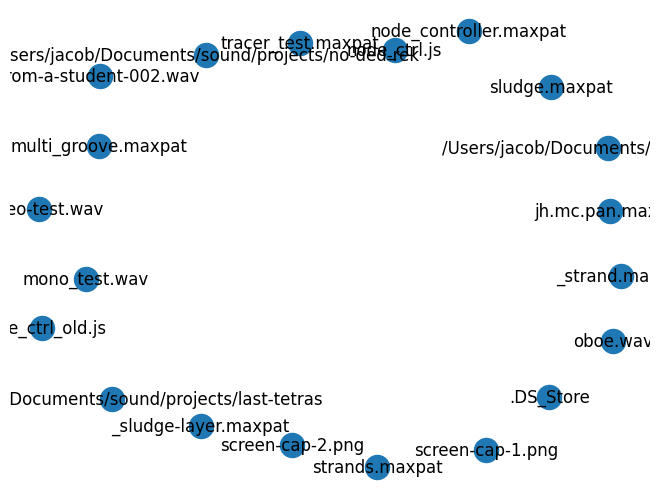

In [6]:
def display_network(graph, **kwargs):
    graph_copy = copy.copy(graph)

    label_map = get_label_map()
    graph_copy = nx.relabel_nodes(graph_copy, label_map)

    if kwargs.get("pos_algo", None) != None:
        pos = apply_layout(graph_copy, kwargs.get("pos_algo"))

        nx.draw(graph_copy, pos = pos, with_labels = True)
        plt.show()
    else:
        nx.draw(graph_copy, with_labels = True)
        plt.show()

def apply_layout(graph: nx.Graph, algo: str) -> dict:
    if algo == "spring":
        pos = nx.spring_layout(graph, seed=3068)
    elif algo == "circular":
        pos = nx.circular_layout(graph)
    elif algo == "fr":
        pos = nx.fruchterman_reingold_layout(graph)
    elif algo == "spectral":
        pos = nx.spectral_layout(graph)
    elif algo == "random":
        pos = nx.random_layout(graph)
    else:
        pos = nx.spring_layout(graph, seed=3068)

    return pos

def get_label_map():
    label_map = {}
    for node_id in node_dict:
        if node_dict[node_id]["has_manifest"]:
            label_map[node_id] = node_dict[node_id]["manifest_item"].title
        else:
            label_map[node_id] = node_dict[node_id]["folder_label"]
    return label_map

display_network(network)

## Adding edges
Next we need to create some edges between the different nodes. We shall process the metadata in the IIIF Manifests to do this (note that this is **not** the metadata of the Manifest item in Arvest). We can get the Manifest's metadata by running the `get_content()` function which will return the IIIF Manifest as a `dict`, and then inspecting the `metadata field`.

The type of network we wish to create will depened on the type of metadata we have available. In our example, we're going to link files to the folders they are contained in, and also create a link between folders that are contained within another folder.

👍 Processed nodes


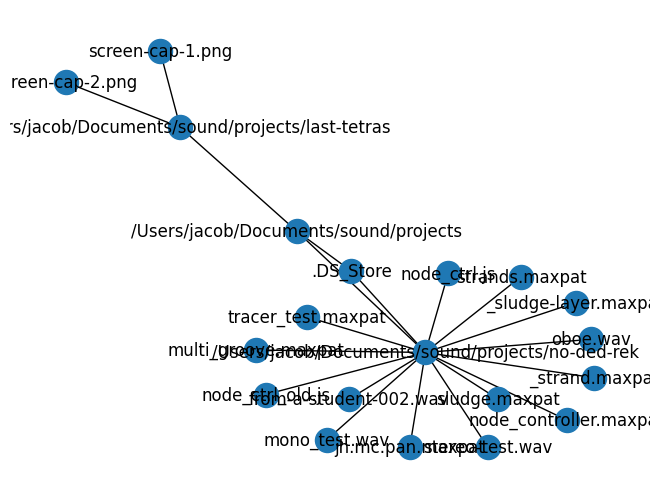

In [7]:
network.remove_edges_from(list(network.edges()))

for node_id in node_dict:
    # Treat nodes that are files:
    if node_dict[node_id]["has_manifest"]:
        node_metadata = node_dict[node_id]["manifest_dict"]["metadata"]
        node_folder = get_metatdata_field(node_metadata, "dir")
        for target_id in node_dict:
            if node_id != target_id:
                if node_dict[target_id]["has_manifest"] == False:
                    if node_dict[target_id]["folder_label"] == node_folder:
                        network.add_edge(node_id, target_id)
    
    # Treat nodes that are folders
    if node_dict[node_id]["has_manifest"] == False:
        this_folder = node_dict[node_id]["folder_label"]
        for target_id in node_dict:
            if node_id != target_id:
                if node_dict[target_id]["has_manifest"] == False:
                    target_folder = node_dict[target_id]["folder_label"]
                    if len(this_folder) < len(target_folder):
                        if target_folder[0:len(this_folder)] == this_folder:
                            network.add_edge(node_id, target_id)

print(f"👍 Processed nodes")
display_network(network)

## Layout algorithms
We can modify the way in which the nodes configure themselves with different layout algorithms. Here are a few you can test:

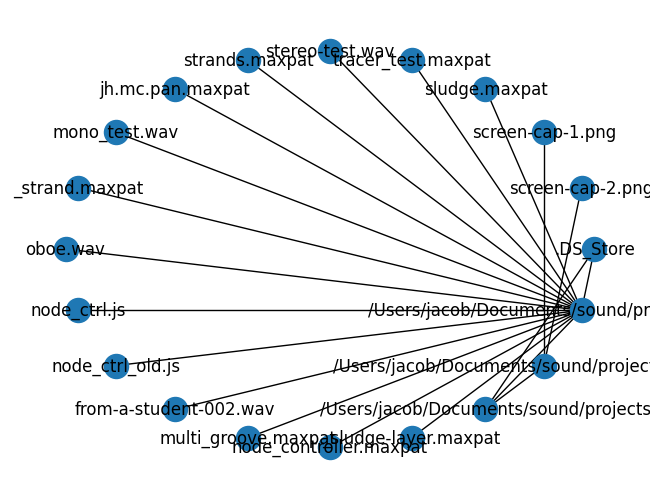

In [8]:
LAYOUT_ALGORITHM = "circular" # Choose between spring, circular, fr, spectral and random

display_network(network, pos_algo = LAYOUT_ALGORITHM)

# 3. Export to Arvest
Finally, we can export this network visualization as an interactive IIIF Manifest that can be viewed directly in Arvest. To do this, we will first need to make a high-res image of the network, keeping track of the position and size of the nodes as they are rendered.

In [9]:
IMAGE_PATH = os.path.join(TEMP_FOLDER, "network_image.png")

image_data = jhutils.images.network_to_image(network, IMAGE_PATH,
    pos_algo = "fr",
    width = 1000, height = 1000,
    size_min_max = [25, 50],
    edge_width = 4, edge_col = (185, 187, 189),
    node_col = (124, 187, 217), node_outline_col = (142, 146, 148)
)

print(f"🎨 Exported image to {IMAGE_PATH}!")

🎨 Exported image to /Users/jacob/Documents/Repos/arvest-data-in-context/ml-notebooks/_local/workflows/network-analysis/01-basic-network-analysis/_TEMP/network_image.png!


Now let's upload this image to Arvest using the `add_media()` function and the [Arvest API](https://github.com/arvest-data-in-context/arvest-api).

In [10]:
added_media = ar.add_media(path = IMAGE_PATH)
added_media.update_title("Network visualization")
added_media.update_description("This was created with a tutorial to demonstrate how to make interactive networks in Arvest.")

media_metadata = added_media.get_metadata()
media_metadata["identifier"] = "&&NETWORK-VIZ-TUT"
added_media.update_metadata(media_metadata)

print("👍 Uploaded to Arvest!")

👍 Uploaded to Arvest!


Now we can use the [arvesttools](https://github.com/arvest-data-in-context/arvest-api-tools) package's helper function `media_to_manifest` to create a Manifest from this item, and add annotations to this manifest for each node.

In [11]:
manifest = arvesttools.manifest_creation.media_to_manifest(added_media)

for node_id in node_dict:
    if node_dict[node_id]["has_manifest"]:
        node_pos_data = image_data[node_id]

        node_pos_annot = {"x" : float(node_pos_data["x"]), "y" : float(node_pos_data["y"]), "w" : float(node_pos_data["size"]), "h" : float(node_pos_data["size"])}
        manifest_url = node_dict[node_id]["manifest_item"].get_full_url()
        manifest_metadata = node_dict[node_id]["manifest_dict"]["metadata"]
        file_name = get_metatdata_field(manifest_metadata, "basename")

        arvesttools.manifest_creation.add_textual_annotation(
            manifest, 0,
            xywh = node_pos_annot,
            linked_manifest = manifest_url,
            text_content = f"<p><strong>{file_name}</strong></p>"
        )

print("👍 Manifest created!")

👍 Manifest created!


Finally, let's upload the Manifest to Arvest, and either view directly with the link that will printed to the console below, or find it in our [workspace](https://workspace.arvest.app).

In [12]:
# Save to disk
local_path = os.path.join(TEMP_FOLDER, "network-viz.json")
write_json(local_path, manifest.dict())

# Upload manifest
add_manifest = ar.add_manifest(path = local_path)
add_manifest.update_title("Network visualization")
add_manifest.update_description("This was created with a tutorial to demonstrate how to make interactive networks in Arvest.")
add_manifest.update_thumbnail_url(added_media.thumbnail_url)

media_metadata = add_manifest.get_metadata()
media_metadata["identifier"] = "&&NETWORK-VIZ-TUT"
add_manifest.update_metadata(media_metadata)

print(f"👍 Uploaded to Arvest! View your Manifest here: {add_manifest.get_preview_url()}")

👍 Uploaded to Arvest! View your Manifest here: https://workspace.arvest.app/manifest/3579eaa3937819e97780b53eb6213c66f57f2848/network-viz.json


# 4. Cleanup
To finish, lets clean up our mess! First, we can delete the temporary folder .

In [ ]:
shutil.rmtree(TEMP_FOLDER)
print(f"🗑️ {TEMP_FOLDER} removed !")

And finally, we can remove from Arvest all of our created Manifest. We can get all of our content by using the `get_manifests()` and `get_medias()` functions, then check the metadata. If it's one of the files we want to remove, we can then use the `remove()` function.

**⚠️ Warning: there's no going back after using the remove function, so be careful! To avoid accidential removal, we've added a `REMOVE` variable that need to be set to `True` for the code to run.**

In [ ]:
REMOVE = False

if REMOVE:
    all_manifests = ar.get_manifests()
    count = 0
    print("Removing content...")

    for i, media_file in enumerate(all_manifests):
        print_progress_bar(i + 1, len(all_manifests), f"(Processing file {i + 1}/{len(all_manifests)})")
        media_metadata = media_file.get_metadata()
        if media_metadata["identifier"] == "&&NETWORK-VIZ-TUT":
            media_file.remove()
            count = count + 1

    all_manifests = ar.get_medias()
    for i, media_file in enumerate(all_manifests):
        print_progress_bar(i + 1, len(all_manifests), f"(Processing file {i + 1}/{len(all_manifests)})")
        media_metadata = media_file.get_metadata()
        if media_metadata["identifier"] == "&&NETWORK-VIZ-TUT":
            media_file.remove()
            count = count + 1

    print(f"🗑️ Removed {count} items!")